In [2]:
import datetime
import warnings
from astropy.io import fits
import webbpsf
import numpy as np
import pprint
import photutils
from matplotlib.colors import LogNorm
import pysiaf
import poppy
import scipy
import multiprocessing
import yaml
%pylab inline

/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in /grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


Populating the interactive namespace from numpy and matplotlib


### Goal: Translate the tip/tilt from a WebbPSF simulation into a pixel vector 

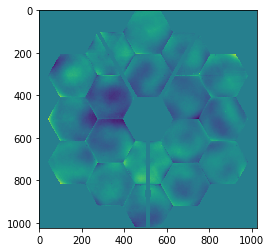

Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
A2	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
A3	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
A4	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
A5	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
A6	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
B1	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
C1	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
B2	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
C2	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
B3	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
C3	     0.0000     0.0000     0.0000     0.0000     

In [7]:
nc = webbpsf.NIRCam()
nc, ote = webbpsf.enable_adjustable_ote(nc)

plt.imshow(ote.opd)
plt.show()
ote.print_state()

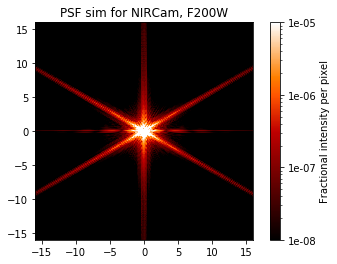

In [10]:
psf = nc.calc_psf(nlambda=30, oversample=1, fov_pixels=1024, add_distortion=False)
webbpsf.display_psf(psf, vmin=1e-8, vmax=1e-5)

Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
A2	    -0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
A3	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
A4	   -30.0000     0.0000     0.0000     0.0000     0.0000     0.0000
A5	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
A6	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
B1	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
C1	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
B2	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
C2	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
B3	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
C3	     0.0000     0.0000     0.0000     0.0000     

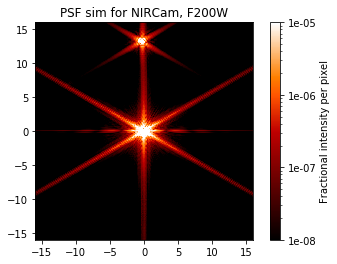

In [316]:
# Add some tilt
ote.reset()
ote.move_seg_local('A4', xtilt=-30, ytilt=0)
ote.print_state()

psf_tilted = nc.calc_psf(nlambda=30, oversample=1, fov_pixels=1024, add_distortion=False)
webbpsf.display_psf(psf_tilted, vmin=1e-8, vmax=1e-5)

Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
A2	     0.0000    30.0000   100.0000     0.0000     0.0000     0.0000
A3	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
A4	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
A5	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
A6	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
B1	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
C1	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
B2	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
C2	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
B3	     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
C3	     0.0000     0.0000     0.0000     0.0000     

x_peak y_peak ...     y_centroid         fit_peak_value   
------ ------ ... ------------------ ---------------------
   511    512 ... 511.48234105660123   0.12354312987561604
   698    865 ...  865.0716293001177 0.0004177629968736724


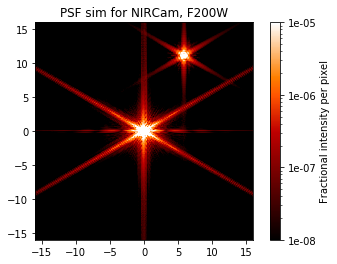

In [312]:
# Add some tilt and piston?
ote.reset()
ote.move_seg_local('A1', xtilt=20, ytilt=10, piston=100)
ote.print_state()

psf_tilted_pistoned = nc.calc_psf(nlambda=30, oversample=1, fov_pixels=1024, add_distortion=False)
webbpsf.display_psf(psf_tilted_pistoned, vmin=1e-8, vmax=1e-5)

sources = photutils.find_peaks(psf_tilted_pistoned[1].data, 1e-4, box_size=50, subpixel=True)
print(sources)

# So it looks like the piston only has an effect on the order of ~10 pixels?

In [20]:
psf_tilted.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     150   (1024, 1024)   float64   
  1  DET_SAMP      1 ImageHDU       152   (1024, 1024)   float64   


In [60]:
psf_data = psf_tilted[1].data

x_peak y_peak       peak_value      ...     y_centroid        fit_peak_value    
------ ------ --------------------- ... ----------------- ----------------------
   511    512   0.08980990724825716 ... 511.5185066440914    0.12684983869653252
   639    782 0.0003716306635364043 ... 781.6984508691717 0.00038924846056573846


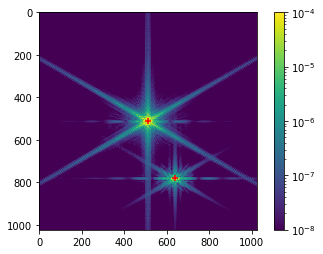

In [59]:
# Find the location of the two PSFs here

sources = photutils.find_peaks(psf_data,1e-4, box_size=50, subpixel=True)
print(sources)

im = plt.imshow(psf_data, norm=LogNorm(), clim=(1e-8, 1e-4))
plt.scatter(sources['x_centroid'], sources['y_centroid'], color='r', marker='+')
plt.colorbar(im)
plt.show()

In [62]:
x_pix_distance = sources['x_centroid'][1] - sources['x_centroid'][0]
y_pix_distance = sources['y_centroid'][1] - sources['y_centroid'][0]
print(x_pix_distance, y_pix_distance)
print(x_pix_distance/10, y_pix_distance/20)

127.66354825351965 270.17994422508025
12.766354825351964 13.508997211254012


## Quantify the relation between tilt and displacement

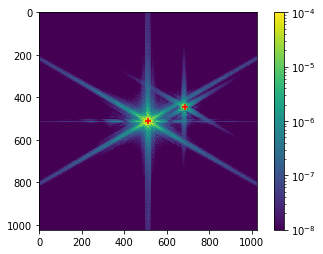

-8.61022010931594 -10.762105387631003
Completed 1/20 calculations


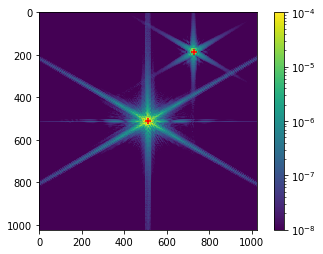

-1.2367924816769182 -29.16480457675165
Completed 2/20 calculations


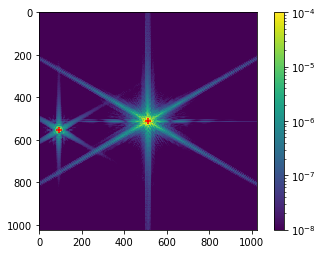

25.183426998346263 18.787061867165193
Completed 3/20 calculations


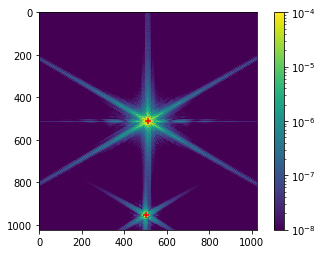

-16.733110981203225 28.710861105294605
Completed 4/20 calculations


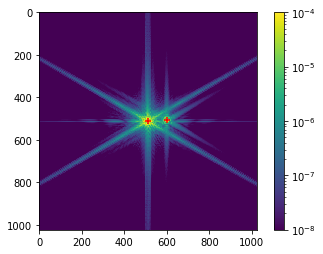

-5.705119749386537 -3.6695355300325083
Completed 5/20 calculations


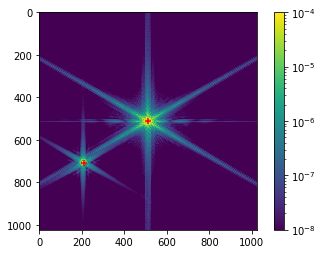

11.82943408948519 24.157870597932664
Completed 6/20 calculations


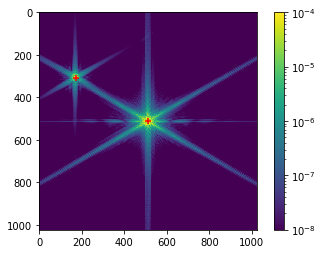

29.887275202207896 0.018329443519068178
Completed 7/20 calculations


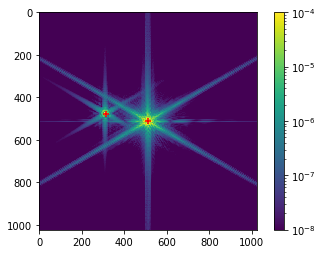

14.200523563179829 5.42081802571316
Completed 8/20 calculations


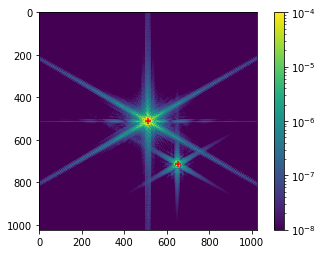

-17.018777014390913 7.602661780987262
Completed 9/20 calculations


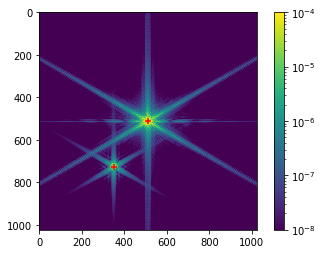

1.766145051383635 19.859124195730956
Completed 10/20 calculations


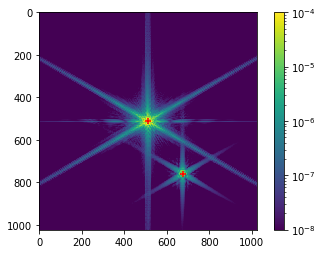

-20.342645369886696 9.47717727535538
Completed 11/20 calculations


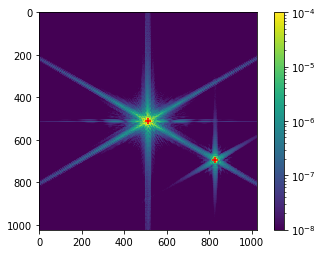

-27.68649243251478 -0.583669880082919
Completed 12/20 calculations


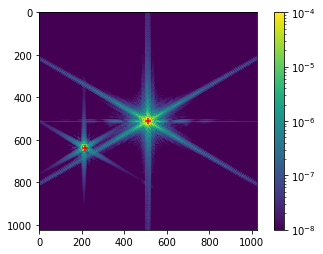

14.29510146550276 19.48917097432639
Completed 13/20 calculations


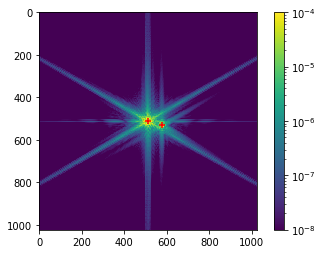

-5.153180486702535 -1.297409384013907
Completed 14/20 calculations


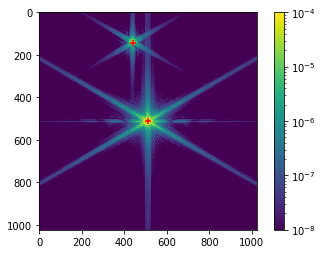

18.914367664973838 -20.919581813125518
Completed 15/20 calculations


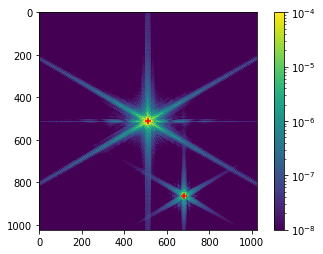

-24.85553554587444 15.861229173801334
Completed 16/20 calculations


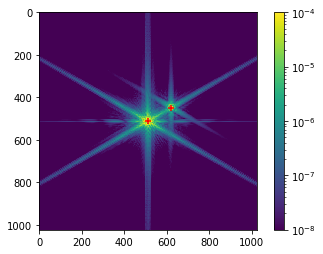

-4.702158723715733 -8.31780703819594
Completed 17/20 calculations


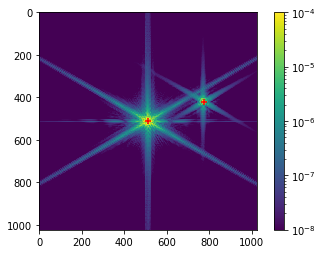

-13.356691949051172 -15.916817353828565
Completed 18/20 calculations


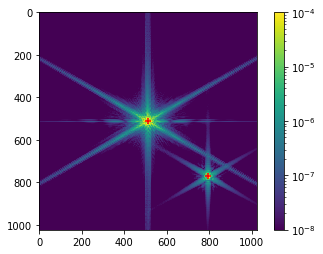

-28.54989014230098 5.647398214148829
Completed 19/20 calculations


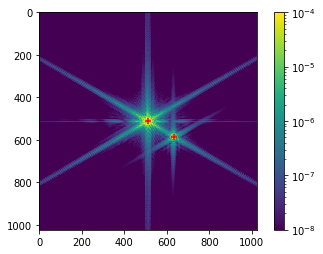

-10.859218978863606 0.1774890100128914
Completed 20/20 calculations
[[-8.61022010931594, -10.762105387631003, <Column name='x_centroid' dtype='float64' length=2>
 683.204683206529
511.4988586129716, <Column name='y_centroid' dtype='float64' length=2>
447.46753723043173
   511.48243896486], [-1.2367924816769182, -29.16480457675165, <Column name='x_centroid' dtype='float64' length=2>
727.3045079587998
511.4988438922343, <Column name='y_centroid' dtype='float64' length=2>
186.23369005656804
511.48247364161176], [25.183426998346263, 18.787061867165193, <Column name='x_centroid' dtype='float64' length=2>
511.4988444486085
94.42365472725174, <Column name='y_centroid' dtype='float64' length=2>
511.4824718857888
553.9208082354075], [-16.733110981203225, 28.710861105294605, <Column name='x_centroid' dtype='float64' length=2>
511.49884475383317
 501.3247403522561, <Column name='y_centroid' dtype='float64' length=2>
511.48246821142345
 955.0403536694578], [-5.705119749386537, -3.6695355300325083,

In [328]:
# Collect information on how the tilt-to-displacement ratio changes over the detector
random_tilts = np.random.random((20, 2)) * 60 - 30

results = []
for i, (x_tilt, y_tilt) in enumerate(random_tilts):
    ote.reset()
    ote.move_seg_local('C1', xtilt=x_tilt, ytilt=y_tilt)
    psf = nc.calc_psf(nlambda=30, oversample=1, fov_pixels=1024, add_distortion=False)
    psf_data = psf[1].data
    sources = photutils.find_peaks(psf_data, 1e-4, box_size=50, subpixel=True)
    
    im = plt.imshow(psf_data, norm=LogNorm(), clim=(1e-8, 1e-4))
    plt.scatter(sources['x_centroid'], sources['y_centroid'], color='r', marker='+')
    plt.colorbar(im)
    plt.show()
    
    results.append([x_tilt, y_tilt, sources['x_centroid'], sources['y_centroid']])
    print(x_tilt, y_tilt)
    print('Completed {}/{} calculations'.format(i + 1, len(random_tilts)))
    
print(results)

In [42]:
def _convert_control_to_global(segment, xtilt, ytilt):
    """Convert vectors coordinates in the local segment control
    coordinate system to NIRCam detector X and Y coordinates.
    At least proportionally."""
    control_xaxis_rotations = {
        'A1': 180, 'A2': 120, 'A3': 60, 'A4': 0,'A5': -60, 
        'A6': -120, 'B1': 0, 'C1': 60, 'B2': -60, 'C2': 0, 
        'B3': -120, 'C3': -60, 'B4': -180, 'C4': -120, 
        'B5': -240, 'C5': -180, 'B6': -300, 'C6': -240
    }

    x_rot = control_xaxis_rotations[segment[:2]]  # degrees
    x_rot_rad = x_rot * np.pi / 180 # radians
    print('Rotating by {} deg ({} rad) to account for segment {}'.format(x_rot, x_rot_rad, segment))
    
    y_det = (xtilt * np.cos(x_rot_rad)) - (ytilt * np.sin(x_rot_rad))
    x_det = (xtilt * np.sin(x_rot_rad)) + (ytilt * np.cos(x_rot_rad))
    
    return x_det, y_det

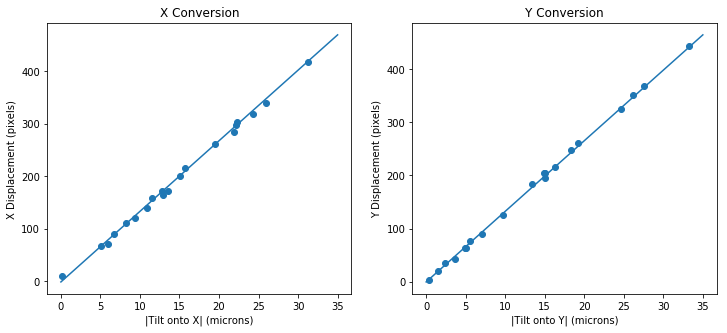

In [368]:
tilt_onto_x = [abs(_convert_control_to_global('C1', x_tilt, y_tilt)[0]) for x_tilt, y_tilt, _, _ in results]
x_displacement = [abs(x_centroids[1] - x_centroids[0]) for _, _, x_centroids, _ in results]

tilt_onto_y = [abs(_convert_control_to_global('C1', x_tilt, y_tilt)[1]) for x_tilt, y_tilt, _, _ in results]
y_displacement = [abs(y_centroids[1] - y_centroids[0]) for _, _, _, y_centroids in results]

fig, [ax1, ax2] = plt.subplots (1, 2, figsize=(12, 5))
x = np.linspace(0, 35, 10)
ax1.scatter(tilt_onto_x, x_displacement)
ax1.plot(x, x * x_slope + x_intercept)
ax1.set_title('X Conversion')
ax1.set_xlabel('|Tilt onto X| (microns)')
ax1.set_ylabel('X Displacement (pixels)')

ax2.scatter(tilt_onto_y, y_displacement)
ax2.plot(x, x * y_slope + y_intercept)
ax2.set_title('Y Conversion')
ax2.set_xlabel('|Tilt onto Y| (microns)')
ax2.set_ylabel('Y Displacement (pixels)')

plt.show()


In [4]:
def generate_random_tilts(i, plot=False):
    x_tilt, y_tilt = random_tilts[i]
    
    nc = webbpsf.NIRCam()
    nc, ote = webbpsf.enable_adjustable_ote(nc)
    ote.move_seg_local(segment , xtilt=x_tilt, ytilt=y_tilt)
    psf = nc.calc_psf(nlambda=30, oversample=1, fov_pixels=1024, add_distortion=False)
    psf_data = psf[1].data
    sources = photutils.find_peaks(psf_data, 1e-4, box_size=50, subpixel=True)

    if plot:
        im = plt.imshow(psf_data, norm=LogNorm(), clim=(1e-8, 1e-4))
        plt.scatter(sources['x_centroid'], sources['y_centroid'], color='r', marker='+')
        plt.colorbar(im)
        plt.show()

    parameters = [x_tilt, y_tilt, sources['x_centroid'], sources['y_centroid']]
    print('    Completed {}/{} simulations'.format(i + 1, len(random_tilts)))
    
    return parameters
    

Calculating segment A1


    Completed 6/20 simulations
    Completed 4/20 simulations
    Completed 3/20 simulations
    Completed 5/20 simulations
    Completed 2/20 simulations
    Completed 1/20 simulations
    Completed 10/20 simulations
    Completed 9/20 simulations
    Completed 7/20 simulations
    Completed 11/20 simulations
    Completed 8/20 simulations
    Completed 12/20 simulations
    Completed 13/20 simulations
    Completed 14/20 simulations
    Completed 15/20 simulations
    Completed 16/20 simulations
    Completed 17/20 simulations
    Completed 18/20 simulations
    Completed 19/20 simulations
    Completed 20/20 simulations
    X slope and intercept: 13.504525688112778 -3.121694343959348
    Y slope and intercept: 13.55778317311922 -2.662046681941291


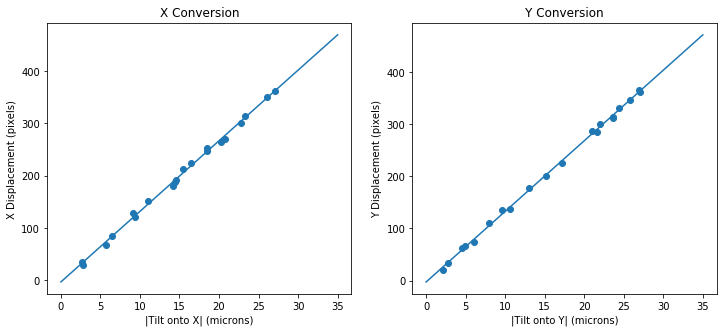

Calculating segment A2


Process ForkPoolWorker-15:
Process ForkPoolWorker-17:
Process ForkPoolWorker-16:
Process ForkPoolWorker-18:
Process ForkPoolWorker-14:
Process ForkPoolWorker-13:
Traceback (most recent call last):
  File "/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._tar

  File "/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/poppy/utils.py", line 1348, in unit_check_wrapper
    return wrapped_function(*bound_args.args, **bound_args.kwargs)
  File "/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/poppy/instrument.py", line 270, in calc_psf
    normalize=normalize)
  File "/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/astropy/utils/decorators.py", line 827, in calc_psf
    func = make_function_with_signature(func, name=name, **wrapped_args)
  File "/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/poppy/poppy_core.py", line 1706, in calc_psf
    normalize=normalize
  File "/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/astropy/utils/decorators.py", line 827, in calc_psf
    func = make_function_with_signature(func, name=name, **wrapped_args)
  File "/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/poppy/utils.py", line 1348, in unit_che

KeyboardInterrupt: 

  File "/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
Process ForkPoolWorker-24:
  File "<ipython-input-384-2929e1466775>", line 7, in generate_random_tilts
    psf = nc.calc_psf(nlambda=30, oversample=1, fov_pixels=1024, add_distortion=False)
  File "/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/webbpsf/webbpsf_core.py", line 783, in calc_psf
    return_intermediates=return_intermediates, normalize=normalize)
  File "/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/poppy/matrixDFT.py", line 488, in perform
    centering=self.centering, offset=offset)
  File "/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/poppy/instrument.py", line 270, in calc_psf
    normalize=normalize)
  File "/Users/lchambers/

  File "/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/poppy/matrixDFT.py", line 208, in matrix_dft
    t1 = np.dot(expYV, plane)
KeyboardInterrupt


    Completed 7/20 simulations
    Completed 18/20 simulations


In [385]:
# Start time: 8:57
# Calculate the slope and intercept for each segment
tilt_to_displacement_params = {}

for segment in webbpsf.constants.SEGNAMES_WSS:
    segment = segment[:2]
    
    random_tilts = np.random.random((20, 2)) * 60 - 30
    
    print('Calculating segment {}'.format(segment))

    # Use multiprocessing to generate all the PSFs
    p = multiprocessing.Pool(6)
    results = p.map(generate_random_tilts, range(20))
    
    if len(results) != 20:
        print('Results is only {} long'.format(len(results)))
        print(results)
        raise ValueError('Something funky happened with the multiprocessing.')
    
    tilt_onto_y = [abs(_convert_control_to_global(segment, x_tilt, y_tilt)[1]) for x_tilt, y_tilt, _, _ in results]
    y_displacement = [abs(y_centroids[1] - y_centroids[0]) for _, _, _, y_centroids in results]
    tilt_onto_x = [abs(_convert_control_to_global(segment, x_tilt, y_tilt)[0]) for x_tilt, y_tilt, _, _ in results]
    x_displacement = [abs(x_centroids[1] - x_centroids[0]) for _, _, x_centroids, _ in results]
    
    x_slope, x_intercept, _, _, _ = scipy.stats.linregress(tilt_onto_x, x_displacement)
    y_slope, y_intercept, _, _, _ = scipy.stats.linregress(tilt_onto_y, y_displacement)
    print('    X slope and intercept:', x_slope, x_intercept)
    print('    Y slope and intercept:', y_slope, y_intercept)
    
    fig, [ax1, ax2] = plt.subplots (1, 2, figsize=(12, 5))
    x = np.linspace(0, 35, 10)
    ax1.scatter(tilt_onto_x, x_displacement)
    ax1.plot(x, x * x_slope + x_intercept)
    ax1.set_title('X Conversion')
    ax1.set_xlabel('|Tilt onto X| (microns)')
    ax1.set_ylabel('X Displacement (pixels)')

    ax2.scatter(tilt_onto_y, y_displacement)
    ax2.plot(x, x * y_slope + y_intercept)
    ax2.set_title('Y Conversion')
    ax2.set_xlabel('|Tilt onto Y| (microns)')
    ax2.set_ylabel('Y Displacement (pixels)')

    plt.show()
    
    params = {}
    params['x'] = [x_slope, x_intercept]
    params['y'] = [y_slope, y_intercept]
    tilt_to_displacement_params[segment] = params


In [53]:
def calc_location_after_tilt(segment, xtilt, ytilt):
    with open('/user/lchambers/OTECommSims/tilt_conversion_parameters.yaml', 'r') as stream:
        d = yaml.load(stream)

    all_slopes = []
    all_intercepts = []
    for _, seg_dict in d.items():
        for axis, axis_dict in seg_dict.items():
            all_intercepts.append(axis_dict['intercept'])
            all_slopes.append(axis_dict['slope'])

    slope = np.average(all_slopes)
    intercept = np.average(all_intercepts)

    print('Slope = {} +/- {}'.format(slope, np.std(all_slopes)))
    print('Intercept = {} +/- {}'.format(intercept, np.std(all_intercepts)))
    
    slope = round(slope, 1)
    intercept = round(intercept, 0)
    
    tilt_onto_x, tilt_onto_y = _convert_control_to_global(segment, xtilt, ytilt)
    print('Tilt projected onto V2/V3:', tilt_onto_x, tilt_onto_y)
    
    x_displacement = tilt_onto_x * slope + intercept
    y_displacement = tilt_onto_y * slope + intercept
    
    return -x_displacement, -y_displacement

In [56]:
with open('/user/lchambers/OTECommSims/tilt_conversion_parameters.yaml', 'r') as stream:
    d = yaml.load(stream)

all_slopes = []
all_intercepts = []
for _, seg_dict in d.items():
    for axis, axis_dict in seg_dict.items():
        all_intercepts.append(axis_dict['intercept'])
        all_slopes.append(axis_dict['slope'])

slope = np.average(all_slopes)
intercept = np.average(all_intercepts)

print(slope, intercept)

13.403764358419311 0.10660509052886072


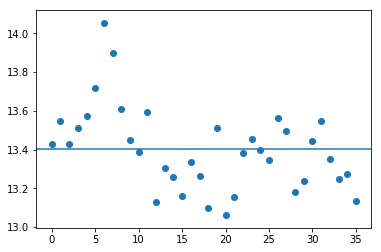

In [60]:
plt.scatter(range(36), all_slopes)
plt.axhline(y=slope)

In [61]:
# TEST!!!!

# Add some tilt
segment = 'A4'
xtilt = 3
ytilt = 30
ote.reset()
ote.move_seg_local(segment, xtilt=xtilt, ytilt=ytilt)
# ote.print_state()

psf_tilted = nc.calc_psf(nlambda=30, oversample=1, fov_pixels=1024, add_distortion=False)
# webbpsf.display_psf(psf_tilted, vmin=1e-8, vmax=1e-5)
psf_data = psf_tilted[1].data

x_displacement, y_displacement = calc_location_after_tilt(segment, xtilt, ytilt)
print(x_displacement, y_displacement)

sources = photutils.find_peaks(psf_data, 1e-4, box_size=50, subpixel=True)
print(sources['x_centroid', 'y_centroid'])

Slope = 13.403764358419311 +/- 0.21318906585060288
Intercept = 0.10660509052886072 +/- 3.0835039081269247
Rotating by 0 deg (0.0 rad) to account for segment A4
Tilt projected onto V2/V3: 30.0 3.0
-402.0 -40.2
    x_centroid         y_centroid    
------------------ ------------------
 94.84006285842207 461.19407282566976
511.49538909266397 511.48912735193363


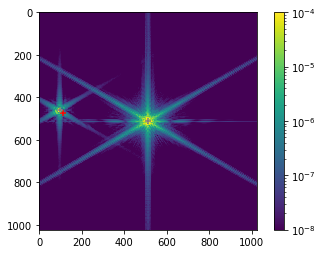

In [62]:
im = plt.imshow(psf_data, norm=LogNorm(), clim=(1e-8, 1e-4))
# plt.scatter(512, 512, color='blue', marker='*')
plt.scatter(512 + x_displacement, 512 + y_displacement, color='r', marker='+')
# plt.scatter(512 + y_displacement, 512 - x_displacement, color='r', marker='X')
plt.scatter(sources['x_centroid'], sources['y_centroid'], color='grey', marker='+')

plt.colorbar(im)
plt.show()

# Make diagram of OTE with segment labels and coordinate systems

In [307]:
def get_transmission_no_struts(self, wave):
    segpaths = {}
#     strutpaths = []
    for segname, vertices in self.segdata:
        segpaths[segname] = matplotlib.path.Path(vertices)
#     for strutname, vertices in self.strutdata:
#         strutpaths.append(matplotlib.path.Path(vertices))

    y, x = wave.coordinates()
    pts = np.asarray([a for a in zip(x.flat, y.flat)])
    npix = wave.shape[0]
    out = np.zeros((npix, npix))

    # paint the segments 1 but leave out the SMSS struts
    for segname, p in segpaths.items():
        res = p.contains_points(pts)
        res.shape = (npix, npix)
        out[res] = 1 if not self.label_segments else int(segname.split('-')[1])
#     for p in strutpaths:
#         res = p.contains_points(pts)
#         res.shape = (npix, npix)
#         out[res] = 0
    return out

In [308]:
wave = poppy.Wavefront()
primary = webbpsf.optics.WebbPrimaryAperture(label_segments=False)
pupil = get_transmission_no_struts(primary, wave)

In [309]:
def convert_meters_to_pixels(x_meters, y_meters):
    """Or at least I think it's meters."""
    x_pixels = x_meters * (1024 / (3.99609375*2)) + 512
    y_pixels = y_meters * (1024 / (3.99609375*2)) + 512
    
    return x_pixels, y_pixels

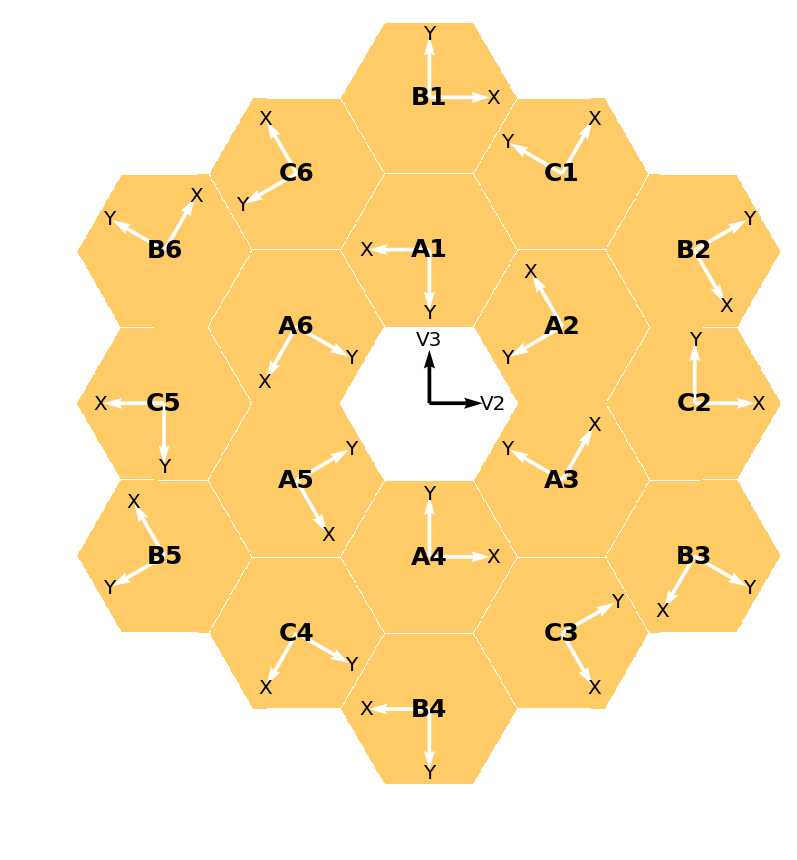

In [380]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

cmap = plt.cm.YlOrRd
cmap.set_under(color='white')
ax.imshow(pupil, cmap=cmap, vmin=0.5, vmax=2.2)
ax.invert_yaxis()
for segment, center in primary.seg_centers.items():
    x_center, y_center = convert_meters_to_pixels(*center)
    ax.text(x_center, y_center, segment[:2], color='black', 
            horizontalalignment='center', verticalalignment='center',
            fontweight='bold', fontsize=25)
    
    x_rot = ote._control_xaxis_rotations[segment[:2]] * np.pi / 180
    x_x = 100 * np.cos(x_rot)
    x_y = 100 * np.sin(x_rot)
    y_rot = (ote._control_xaxis_rotations[segment[:2]] + 90) * np.pi / 180
    y_x = 100 * np.cos(y_rot)
    y_y = 100 * np.sin(y_rot)
    
    seg_x_axis = ax.quiver([x_center], [y_center], [x_x], [x_y], color=['white'], angles='xy', scale_units='xy', scale=1.5, width=5e-3)
    seg_y_axis = ax.quiver([x_center], [y_center], [y_x], [y_y], color=['white'], angles='xy', scale_units='xy', scale=1.5, width=5e-3)
    
    x_label = ax.text(x_center + 0.7 * x_x, y_center + 0.7 * x_y, 'X', color='black', 
                        horizontalalignment='center', verticalalignment='center', fontsize=20)
    y_label = ax.text(x_center + 0.7 * y_x, y_center + 0.7 * y_y, 'Y', color='black', 
                        horizontalalignment='center', verticalalignment='center', fontsize=20)
    

# Add V2/V3 vectors
v2 = ax.quiver([512], [512], [100], [0], angles='xy', scale_units='xy', scale=1.7, width=5e-3)
v3 = ax.quiver([512], [512], [0], [100], angles='xy', scale_units='xy', scale=1.7, width=5e-3)
v2_label = ax.text(512 + 0.7 * 100, 512 + 0.7 * 0, 'V2', color='black', 
                    horizontalalignment='center', verticalalignment='center', fontsize=20)
v3_label = ax.text(512 + 0.7 * 0, 512 + 0.7 * 100, 'V3', color='black', 
                    horizontalalignment='center', verticalalignment='center', fontsize=20)
    
    
ax.set_xlabel('X [V2]') 
ax.set_ylabel('Y [V3]')
ax.set_xlim(90, 910)
ax.set_ylim(50, 950)
ax.axis('off')
plt.savefig('JWST Segments and Coordinates.png', transparent=True)
plt.show()